In [146]:
import unidecode
import re
import numpy as np
import nltk 
import string
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructField, StructType, IntegerType
import pyspark.sql.functions as F

# model tools
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.rslp import RSLPStemmer

# plot
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

stemmer = RSLPStemmer()

In [109]:
def text_preprocessing(instancia):

    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    
    instancia = instancia.lower()
    instancia = re.sub('\d+', '', str(instancia)).replace("&gt;"," ").replace("&lt;"," ") 
    instancia = re.sub(r"https?:\/\/\S+","", instancia)
    instancia = re.sub(r"@[A-Za-z0-9\w]+","", instancia)
    instancia = re.sub(r"#[A-Za-z0-9\w]+","", instancia)
    instancia = re.sub('^RT ',' ',instancia)
    instancia = re.sub(r"http\S+", "", instancia) 
    instancia = re.sub(r'([A-Za-z])\1{2,}', r'\1', instancia)
    instancia = instancia.translate(trantab).replace("\n"," ")
    instancia = unidecode.unidecode(instancia)

    # #Lista de  stopwords no idioma portugues
    stopwords = [unidecode.unidecode(w) for w in list(set(nltk.corpus.stopwords.words('portuguese')))]

    # #guarda no objeto palavras
    palavras = [i for i in instancia.split() if not i in stopwords]
    
    palavras = [re.sub(r'(ha)\1+', r'\1',word) for word in palavras]
    palavras = [re.sub(r'(uha)\1+', r'\1',word) for word in palavras]
    palavras = [stemmer.stem(word) for word in palavras]

    palavras = " ".join(palavras) \
        .strip() \
        .replace('"','') \
        .replace('.','') \
        .replace('-','') \
        .replace('_','') \
        .replace('*','') \
        .replace('>','') \
        .replace('<','') \
        .replace('!','') \
        .replace('?','') \
        .replace('[','') \
        .replace(']','') \
        .replace('\'','') \
        .replace('rt ','')

    return "-" if palavras.strip()=="" else palavras.strip()

In [3]:
# SPARK INSTANCE
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.memory","4G") \
    .config("spark.driver.memory","4G") \
    .config("spark.executor.cores","12") \
    .getOrCreate()

22/05/15 09:54:01 WARN Utils: Your hostname, daholive-Dell-G15-5510 resolves to a loopback address: 127.0.1.1; using 192.168.0.114 instead (on interface wlp0s20f3)
22/05/15 09:54:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/daholive/anaconda3/envs/twiiter_tensor/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/daholive/.ivy2/cache
The jars for the packages stored in: /home/daholive/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8e2dd754-6f02-4b1b-8c4f-bdc649109ca9;1.0
	confs: [default]
	found io.delta#delta-core_2.12;1.1.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
:: resolution report :: resolve 169ms :: artifacts dl 8ms
	:: modules in use:
	io.delta#delta-core_2.12;1.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	org.codehaus.jackson#jackson-core-asl;1.9.13 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|   

In [110]:
# DADOS
dataframe = spark.read.options(
    delimiter=';',
    header='True').csv("/home/daholive/Documents/twitter_ellection_brazil/datasource/TweetsWithTheme_v2.csv")

In [111]:
###############################################################################
## PREPROCESSING WITH SPARK
###############################################################################
from pyspark.sql.types import StringType, IntegerType

dataframe = dataframe.withColumn("sentiment_map", F.when(F.col("sentiment")=="Negativo", 0).otherwise(1))

rdd2 = dataframe.rdd.map(lambda x: (text_preprocessing(x.tweet_text),x.sentiment_map))

schema = StructType([       
    StructField('features', StringType(), True),
    StructField('label', StringType(), True),
])

# create metadata dataframe
df_features = spark.createDataFrame(rdd2, schema = schema)

count_map = F.udf( 
    lambda x: len(x.split()),
    IntegerType()     
)

df_features = df_features \
    .filter(F.col("features")!="-") \
    .dropDuplicates(subset = ['features'])

In [112]:
feature_counts = df_features.select( 
    count_map( F.col('features') ).alias('features_count') 
).toPandas()['features_count'].values

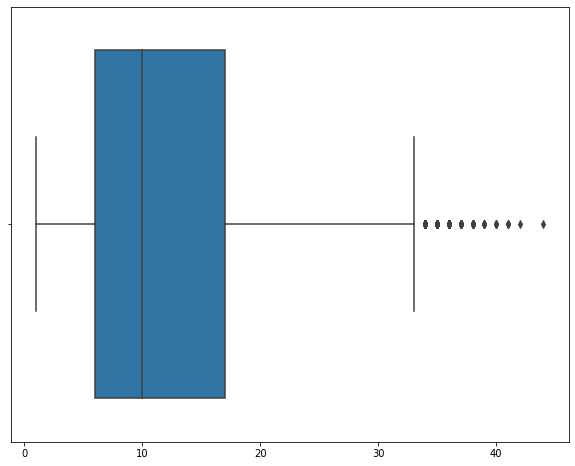

In [113]:
plt.rcParams['figure.figsize'] = [10, 8]
ax = sns.boxplot(x=feature_counts)
plt.show()

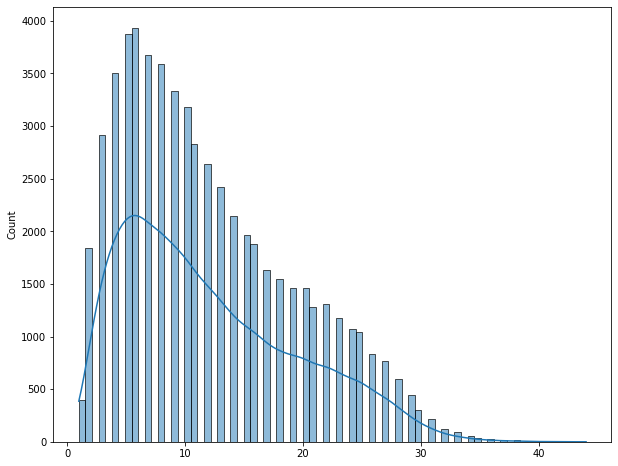

In [114]:
plt.rcParams['figure.figsize'] = [10, 8]
ax2 = sns.histplot(x=feature_counts, kde=True)
plt.show()

In [115]:
df_features = df_features \
    .filter( count_map(F.col("features"))<30 ) 

In [116]:
new_feature_counts = df_features.select( count_map( F.col('features') ).alias('features_count') ).toPandas()['features_count'].values

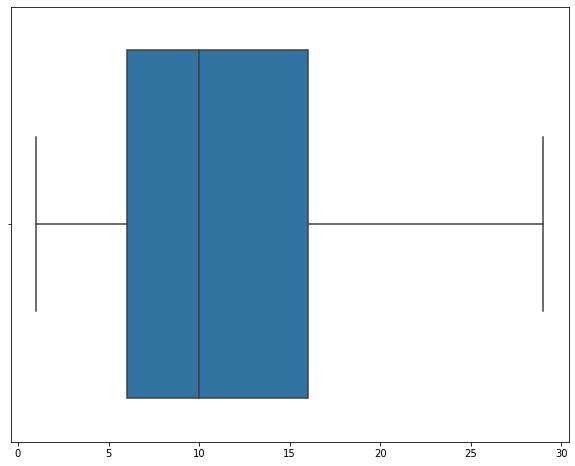

In [117]:
plt.rcParams['figure.figsize'] = [10, 8]
ax = sns.boxplot(x=new_feature_counts)
plt.show()

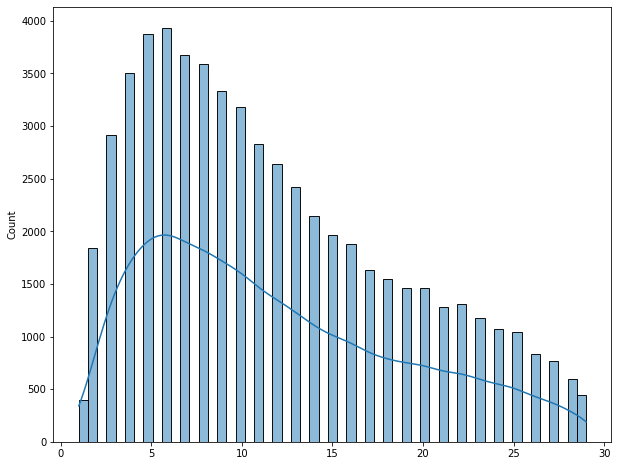

In [118]:
plt.rcParams['figure.figsize'] = [10, 8]
ax2 = sns.histplot(x=new_feature_counts, kde=True)
plt.show()

In [119]:
df_features.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|27446|
|    1|31313|
+-----+-----+



In [120]:
# dataset balanceado
train = df_features.sampleBy("label", fractions={'0': 1, '1': 0.87}, seed=10)
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|27446|
|    1|27175|
+-----+-----+



In [121]:
###############################################################################
## FEATURE AND LABEL DEFINITION
###############################################################################
features = train.select('features').rdd.flatMap(lambda x: x).collect()

labels = train.select('label').rdd.flatMap(lambda x: x).collect()

In [122]:
###############################################################################
## TFIDF
###############################################################################
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Bigram Counts
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),  min_df=2, max_df=0.95, max_features=5000)
bigram_vectorizer.fit(features)
X_train_bigram = bigram_vectorizer.transform(features)

# Bigram Tf-Idf
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [136]:
###############################################################################
## MODEL TESTS  LogisticRegression
###############################################################################
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import RandomizedSearchCV

def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.7, random_state=42
    )

    clf = LogisticRegression(
        class_weight='balanced'
    )
    
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    max_iter = [10000]
    grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=max_iter)
    
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)

    random_search_cv = RandomizedSearchCV(
        estimator=clf,
        param_distributions=grid,
        n_jobs=-1, 
        cv=kfold,
        n_iter=20
    )

    random_search_cv.fit(X_train, y_train)
    y_pred_train = random_search_cv.predict(X_train)
    y_pred_valid = random_search_cv.predict(X_valid)

    print(classification_report_imbalanced(y_train, y_pred_train))
    print(classification_report_imbalanced(y_valid, y_pred_valid))

    return { 
        'y_train':y_train,
        'y_pred_train':y_pred_train,
        'y_valid':y_valid,
        'y_pred_valid': y_pred_valid
    }

y_train = labels

data_return = train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.77      0.83      0.79      0.80      0.63     19174
          1       0.78      0.83      0.77      0.80      0.80      0.64     19060

avg / total       0.80      0.80      0.80      0.80      0.80      0.64     38234

                   pre       rec       spe        f1       geo       iba       sup

          0       0.77      0.72      0.78      0.75      0.75      0.56      8272
          1       0.74      0.78      0.72      0.76      0.75      0.57      8115

avg / total       0.75      0.75      0.75      0.75      0.75      0.57     16387



### CONFUSION MATRIX - LogisticRegression

In [135]:
from pretty_confusion_matrix import pp_matrix_from_data

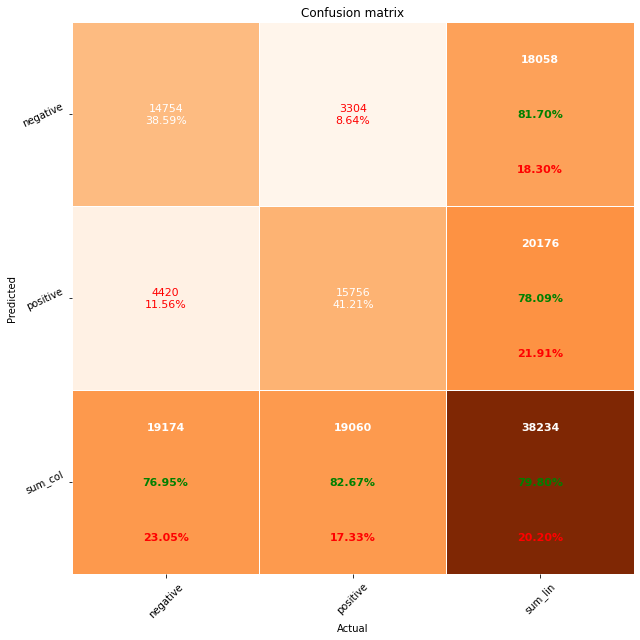

In [142]:
pp_matrix_from_data(data_return['y_train'], data_return['y_pred_train'],columns=['negative','positive'])

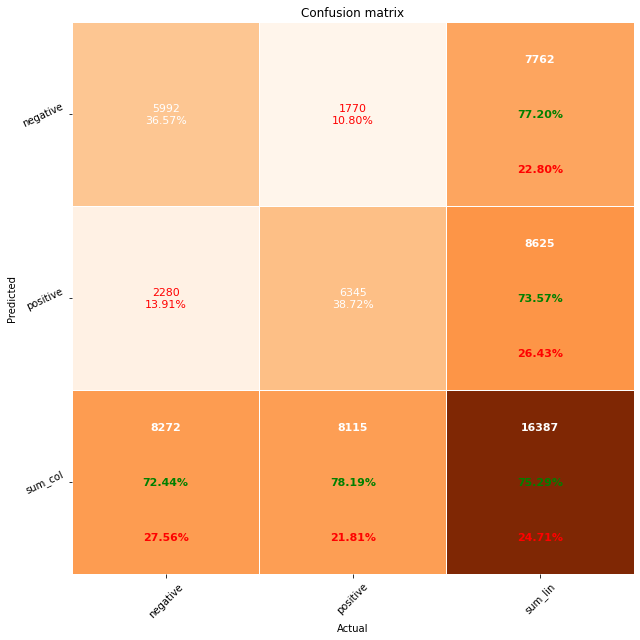

In [143]:
pp_matrix_from_data(data_return['y_valid'], data_return['y_pred_valid'],columns=['negative','positive'])

In [145]:
###############################################################################
## MODEL TESTS  MultinomialNB
###############################################################################
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import RandomizedSearchCV

def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.7, random_state=42
    )

    clf = MultinomialNB()

    alpha = [100, 10, 1.0, 0.1, 0.01]
    grid = dict(alpha=alpha)
    
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)

    random_search_cv = RandomizedSearchCV(
        estimator=clf,
        param_distributions=grid,
        n_jobs=-1, 
        cv=kfold,
        n_iter=20
    )

    random_search_cv.fit(X_train, y_train)
    y_pred_train = random_search_cv.predict(X_train)
    y_pred_valid = random_search_cv.predict(X_valid)

    print(classification_report_imbalanced(y_train, y_pred_train))
    print(classification_report_imbalanced(y_valid, y_pred_valid))

y_train = labels

train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.75      0.80      0.77      0.78      0.60     19174
          1       0.76      0.80      0.75      0.78      0.78      0.61     19060

avg / total       0.78      0.78      0.78      0.78      0.78      0.60     38234

                   pre       rec       spe        f1       geo       iba       sup

          0       0.76      0.72      0.77      0.74      0.74      0.55      8272
          1       0.73      0.77      0.72      0.75      0.74      0.55      8115

avg / total       0.74      0.74      0.74      0.74      0.74      0.55     16387

